In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import sys

import matplotlib.pyplot as plt 
import time   

import os
import argparse




### 1.1 Enable GPU

From "Edit -> Notebook Settings -> Hardware accelerator" select GPU. With the following we will specify to PyTorch that we want to use the GPU.

In [2]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


### 2 Model Definition


In the original paper there are two different frameworks; ResNet and VGG. In this section, different models for different frameworks are created. However, in the original paper different normalization methods are applied in these frameworks and as mentioned the authors of the paper propose a new method which is called momentum Batch Normalization. In ResNet and VGG frameworks a naive batch normalization block is used and modified according to the proposed Momentum Batch Normalization method. On the other hand, Pytorch functions are used directly for other normalization methods such as Group Normalization, Layer Normalization, Instance Normalization and Batch Normalization for ResNet. 

### 2.1 ResNet

ResNet18, ResNet34 and ResNet50 architectures are defined according to the original paper as folllows.

In [3]:
class BasicBlock(nn.Module):
    coefficient = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.InstanceNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.InstanceNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.coefficient*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.coefficient*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.InstanceNorm2d(self.coefficient*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    coefficient = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.InstanceNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.InstanceNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.coefficient *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.InstanceNorm2d(self.coefficient*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.coefficient*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.coefficient*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.InstanceNorm2d(self.coefficient*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.InstanceNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.coefficient, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.coefficient
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


### 2.2 VGG

VGG11 and VGG16 architectures are defined according to the original paper as folllows.


In [4]:
configuration = {
    'VGG11': [64, 'pool', 128, 'pool', 256, 256, 'pool', 512, 512, 'pool', 512, 512, 'pool'],
    'VGG16': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 256, 'pool', 512, 512, 512, 'pool', 512, 512, 512, 'pool']
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(configuration[vgg_name])
        self.classifier = nn.Linear(512, 100)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, configuration):
        layers = []
        in_channels = 3
        for x in configuration:
            if x == 'pool':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


## 3 The Dataset

In the original paper authors used CIFAR10 and CIFAR100 datasets. In this section torchvision function is used to load train/test datasets;  

*   There are 50000 training images and 10000 test images for  10 different classes for CIFAR10
*   There are 50000 training images and 10000 test images for 100 different classes for CIFAR100.

In the original paper, authors mentions standard data augmentation and preprocessing techniques are used but any specific parameters were not given in the paper or in the supplementary material of the paper. Therefore, data augmentation and preprocessing techniques are taken from the literature and applied to the datasets. 



In [5]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
])

###################
batch_size=32 #batch size (2 per gpu)
m0=32 #ideal batch size
######################


trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2) # 4 gpu

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)


==> Preparing data..



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 4 Define and Train Model
In this section user can choose the model between the ResNet18, ResNet34, ResNet50, VGG11 and VGG16 frameworks. 

### 4.1 Define Loss Function and the Optimizer

Instance is created for the model based on the choice.

In the original paper authors used Stochastic Gradient Descent for the optimization with the momentum 0.9 and weight decay 0.0001 paramaeters set. In the experiments these parameters and optimization method from the paper are preserved.

Since the criterion for the loss function is not specified exactly in the original paper Cross-Entropy Loss method is chosen in the experiments.





In [6]:
sys.argv=['']
del sys


best_acc = 0  # best test accuracy
start_epoch = 1  


# Model
print('==> Building model..')

#net = VGG('VGG11')
# net = VGG('VGG16')
net = ResNet18()
# net = ResNet34()
# net = ResNet50()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.1*batch_size/64,
                      momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 180], gamma=0.1)



==> Building model..


### 4.2 Train the Model

In the original paper, authors propose a new method in order to train large datasets with small batch-sizes for insufficient memory resources. Therefore, in the experiments considerably smaller batch sizes are used and it extends the training times. In order to overcome high training times problem GPU usage becomes a necessity and cuda is used in the experiments with Colab Pro.



In [7]:
# Training and Accuracy Calculation
def train(verbose=True):
    
    loss_history=[]
    net.train()
    correct = 0
    total = 0
    for epoch in range(start_epoch, start_epoch+epoch_number):
      
      start = time.time()
      for batch_idx, (inputs, targets) in enumerate(trainloader):
          inputs, targets = inputs.to(device), targets.to(device)
          
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()


          loss_history.append(loss.item()) 

      end = time.time()
      if verbose: print(f'Epoch {epoch} / {epoch_number}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5} , Time : {end - start} seconds')            

      global best_acc
      global test_loss
      net.eval()
      test_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
          for batch_idx, (inputs, targets) in enumerate(testloader):
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = net(inputs)  
              _, predicted = outputs.max(1)
              total += targets.size(0)
              correct += predicted.eq(targets).sum().item()       


      acc = 100.*correct/total
      historyy.append(acc)

      print('acc:',acc,'best_acc:',best_acc)
      if acc > best_acc:
          print('Saving..' )
          
          state = {
              'net': net.state_dict(),
              'acc': acc,
              'epoch': epoch,
          }
          best_acc = acc
          
      print('\n\n') 
      scheduler.step() 
    return loss_history      

In [8]:
epoch_number=200
historyy=[]
losses=[]


loss_history=train()


Epoch 1 / 200: avg. loss of last 5 iterations 1.9490187168121338 , Time : 46.63041543960571 seconds
acc: 33.92 best_acc: 0
Saving..



Epoch 2 / 200: avg. loss of last 5 iterations 1.4864450454711915 , Time : 46.42307209968567 seconds
acc: 50.42 best_acc: 33.92
Saving..



Epoch 3 / 200: avg. loss of last 5 iterations 0.9744116067886353 , Time : 46.4380669593811 seconds
acc: 58.92 best_acc: 50.42
Saving..



Epoch 4 / 200: avg. loss of last 5 iterations 0.7595643043518067 , Time : 46.45994305610657 seconds
acc: 70.49 best_acc: 58.92
Saving..



Epoch 5 / 200: avg. loss of last 5 iterations 0.8432305932044983 , Time : 46.503077268600464 seconds
acc: 74.15 best_acc: 70.49
Saving..



Epoch 6 / 200: avg. loss of last 5 iterations 0.7268842816352844 , Time : 46.46044898033142 seconds
acc: 75.64 best_acc: 74.15
Saving..



Epoch 7 / 200: avg. loss of last 5 iterations 0.6119071304798126 , Time : 46.53094458580017 seconds
acc: 79.06 best_acc: 75.64
Saving..



Epoch 8 / 200: avg. loss of las

### 4.3 The Loss Curve
Loss curve is visualized.

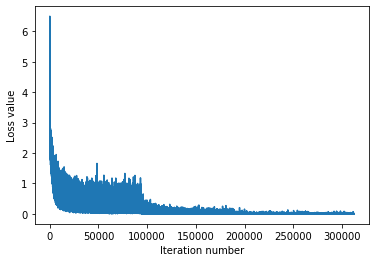

In [9]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 4.4 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. 

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))  

Accuracy of the network on the 10000 test images: 93 %


In [11]:
print('saving' ,'acc:',best_acc)

saving acc: 93.4


### 5 Results

Accuracy vs epoch is plotted according to the test results. 

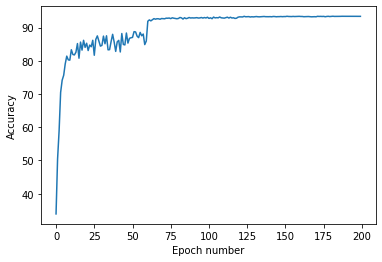

[33.92, 50.42, 58.92, 70.49, 74.15, 75.64, 79.06, 81.4, 80.27, 80.19, 83.32, 81.89, 81.76, 82.57, 85.18, 80.77, 85.62, 83.21, 86.16, 84.03, 85.28, 83.08, 84.73, 84.22, 86.17, 81.66, 86.44, 87.49, 85.93, 84.41, 84.63, 87.42, 85.12, 87.52, 83.29, 83.35, 85.78, 87.96, 85.65, 82.82, 85.69, 86.14, 82.65, 88.2, 84.91, 84.77, 88.35, 85.32, 86.75, 86.93, 87.03, 88.76, 88.69, 87.4, 86.96, 88.53, 87.52, 88.04, 84.87, 85.94, 91.9, 92.3, 92.01, 92.35, 92.68, 92.51, 92.65, 92.63, 92.5, 92.71, 92.69, 92.64, 92.82, 92.8, 92.86, 92.69, 92.93, 92.81, 92.74, 92.65, 92.73, 93.03, 92.91, 92.55, 92.95, 92.68, 92.8, 93.02, 92.87, 92.92, 92.88, 92.91, 92.98, 92.86, 92.89, 93.02, 92.85, 93.01, 92.88, 93.1, 92.75, 92.94, 92.66, 93.15, 92.9, 92.98, 92.92, 93.18, 92.93, 92.87, 92.83, 92.97, 93.12, 92.85, 93.11, 92.87, 92.94, 92.74, 92.81, 93.12, 93.22, 93.22, 93.19, 93.38, 93.24, 93.25, 93.29, 93.17, 93.25, 93.2, 93.25, 93.31, 93.24, 93.22, 93.26, 93.27, 93.33, 93.27, 93.26, 93.26, 93.28, 93.24, 93.33, 93.31, 93

In [12]:
plt.plot(historyy)
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()
print(historyy)